# Create our image database

In [1]:
!pip install -U -r requirements.txt

Requirement already up-to-date: duckduckgo_search in /home/explore/miniconda3/envs/fastai/lib/python3.8/site-packages (from -r requirements.txt (line 1)) (2.2.2)
Requirement already up-to-date: html5lib in /home/explore/miniconda3/envs/fastai/lib/python3.8/site-packages (from -r requirements.txt (line 2)) (1.1)
Requirement already up-to-date: BeautifulSoup4 in /home/explore/miniconda3/envs/fastai/lib/python3.8/site-packages (from -r requirements.txt (line 3)) (4.11.1)
     |████████████████████████████████| 3.1 MB 2.4 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.2.0
    Uninstalling Pillow-7.2.0:
      Successfully uninstalled Pillow-7.2.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pycaret 2.3.

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')


## Download cheeses

### ddg test

In [3]:
urls = search_images('french cheese', max_images=1)
urls[0]

'https://www.fodors.com/wp-content/uploads/2019/05/HERO_FrenchCheesesNeverHeardOf_Heroshutterstock520248970.jpg'

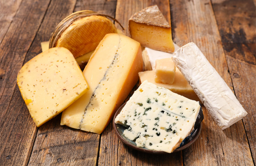

In [4]:
from fastdownload import download_url
dest = 'cheese.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

There are a lot of different ones on this picture. Maybe I could create a list of given cheeses and search specifically for those.

### cheeses category

#### wikipedia with pandas

could try to use that list from [Wikipedia](https://fr.wikipedia.org/wiki/Liste_de_fromages_fran%C3%A7ais)

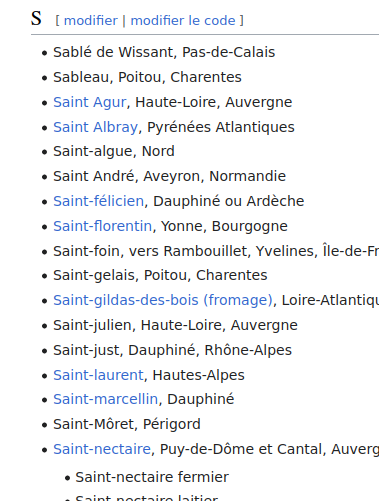

In [5]:
import pandas as pd
cheeses_page_url = 'https://fr.wikipedia.org/wiki/Liste_de_fromages_fran%C3%A7ais'
pd.read_html(cheeses_page_url, attrs={"class": "wikipedia_table"})

ValueError: No tables found

#### leguidedufromage with pandas

In [ ]:
import pandas as pd
cheeses_page_url = 'https://www.leguidedufromage.com/liste-fromages-ordre-alphabetique-wo377.html'
pd.read_html(cheeses_page_url, attrs={"class": "table"})

#### wikipedia with bs4

In [ ]:
import requests
from bs4 import BeautifulSoup

cheeses_page_url = 'https://fr.wikipedia.org/wiki/Liste_de_fromages_fran%C3%A7ais'

r = requests.get(cheeses_page_url)
soup =   BeautifulSoup(r.content,"lxml")
w3schollsList = soup.find_all('body')
for w3scholl in w3schollsList:
    ulList = w3scholl.find_all('li')
    for li in ulList:
        print(li)


#### static list

from this site:
https://www.maison-lorho.fr/blog/le-top-10-des-fromages-preferes-des-francais-n140

In [6]:
FROMAGES = ['camembert', 'brie', 'comté', 'reblochon', 'roquefort', 'raclette', 'saint-nectaire', 'époisse', "mont d'or", "brocciu"]

### download with ddg


In [7]:
import random
random.choice(FROMAGES)

'roquefort'

In [8]:
import random

random_cheese = random.choice(FROMAGES)
urls = search_images('fromage '+random_cheese, max_images=1)
random_cheese, urls[0]

('roquefort',
 'https://fromages-de-saison.com/wp-content/uploads/2020/09/Roquefort-Carles-AOP.jpg')

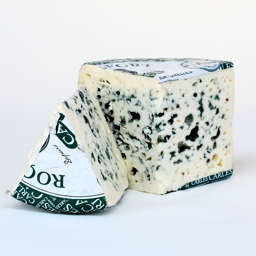

In [9]:
from fastdownload import download_url
dest = 'cheese {}.jpg'.format(random_cheese)
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

### download 200 from each

In [10]:
searches = FROMAGES
path = Path('cheeses')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} fromage'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)


/home/explore/miniconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/explore/miniconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/explore/miniconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/explore/miniconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/explore/miniconda3/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

21

## dataloaders

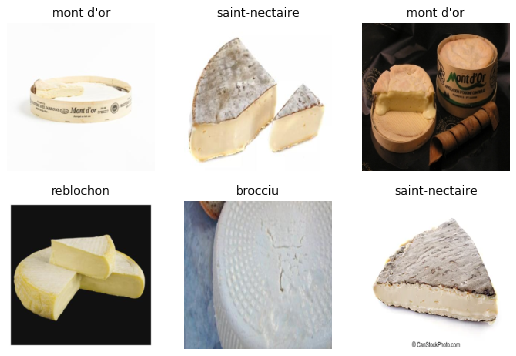

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

## fine_tune

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/explore/miniconda3/envs/fastai/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/explore/miniconda3/envs/fastai/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/explore/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


## use it

In [21]:
is_roquefort,_,probs = learn.predict(PILImage.create('cheese roquefort.jpg'))
print(f"This is a: {is_roquefort}.")
print(f"Probability it's a roquefort: {probs[list(learn.dls.vocab).index('roquefort')]:.4f}")

This is a: roquefort.
Probability it's a roquefort: 1.0000


In [16]:
learn.predict(PILImage.create('cheese roquefort.jpg'))

('roquefort',
 TensorBase(7),
 TensorBase([2.1520e-09, 3.2088e-07, 2.9565e-07, 3.7435e-07, 5.4171e-07,
             1.7218e-08, 7.5776e-09, 1.0000e+00, 7.6769e-10, 1.4500e-09]))

Our label: roquefort


This is a: roquefort.
Probability it's a roquefort: 100.0%


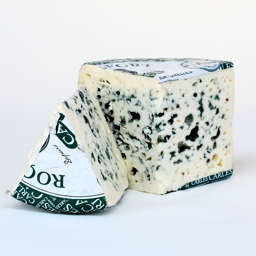

In [35]:
import random

random_cheese = random.choice(FROMAGES)
print(f'Our label: {random_cheese}')
urls = search_images('fromage '+random_cheese, max_images=1)
from fastdownload import download_url
dest = 'cheese {}.jpg'.format(random_cheese)
download_url(urls[0], dest, show_progress=False)

what_is_it,_,probs = learn.predict(PILImage.create('cheese {}.jpg'.format(random_cheese)))
print(f"This is a: {what_is_it}.")
print(f"Probability it's a {random_cheese}: {100*probs[list(learn.dls.vocab).index(random_cheese)]:.1f}%")

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

# export our model

In [36]:
learn.export('model.pkl')